In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Affine

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Read Trajectory

In [3]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s # 100
dt = 2e-5 # unit: s  # Integration Times 1ps
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [6]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_varyD_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq");

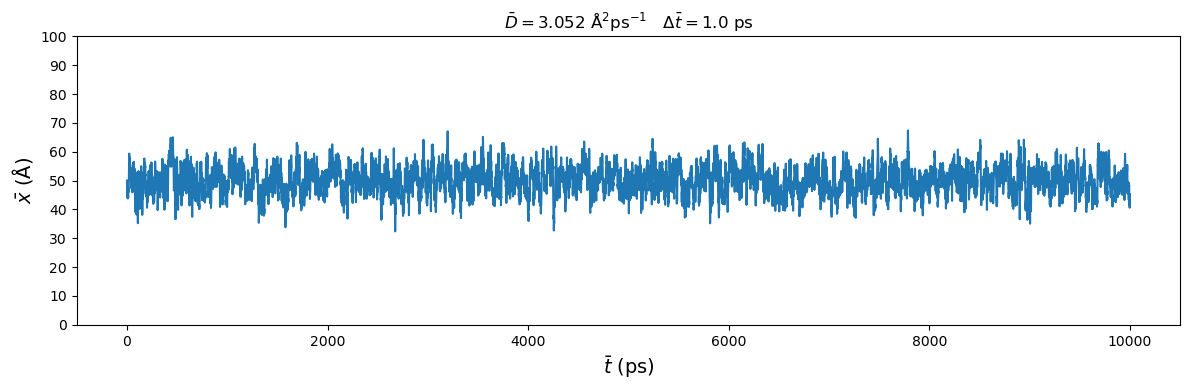

In [7]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record_ps, y_record_ps)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:10:100)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/ps_traj.svg")
plt.show()

### Part 3: Convert physical-space trajectory into reduced-space trajectory

In [8]:
y_record = Affine.length_transform.(y_record_ps)
t_record = Affine.time_transform.(t_record_ps)
D = Affine.D_transform(D_ps);

In [9]:
# physical parameters
save_freq = Affine.time_transform(save_freq_ps)
total_times = Affine.time_transform(total_times_ps)
dt = Affine.time_transform(dt_ps)
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


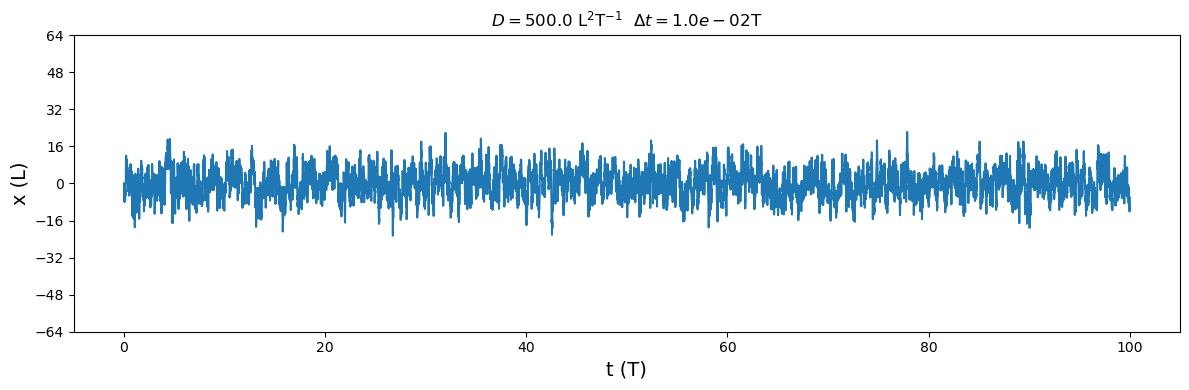

In [11]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: Set the force constant($\sigma$ of Gaussian) of Photon Operator

In [12]:
## Photon Operator
sigma_photon = 1 # unit: L
k_photon = get_k_by_sigma(sigma_photon)
sigma_photon_scan_D = 0.5
k_photon_scan_D = get_k_by_sigma(sigma_photon_scan_D);

### Part 5: Set Flat potential as $p_0$

In [13]:
V0 = symmetry_wall_potential.(-64., 64., 2.5, 10.0, xref)
rho_0 = get_rhoeq(V0, w0)
p0 = rho_0 .* rho_0;

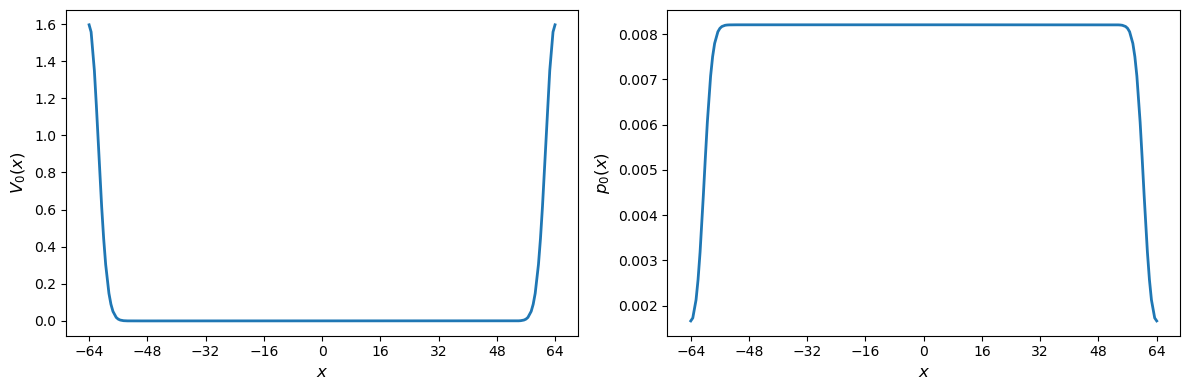

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, V0, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V_0(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, p0, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{0}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
plt.show()

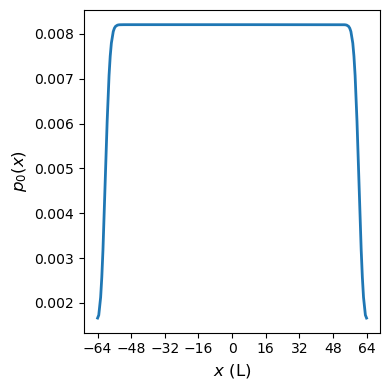

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

ax.plot(xref, p0, linewidth=2)
ax.set_xlabel("\$x\$ (L)", fontsize=12)
ax.set_ylabel("\$p_{0}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/p0.svg")
plt.show()

### Part 5: Alternative, Set KDE as initial guess

In [101]:
σ_kde = 8.
k_kde = get_k_by_sigma(σ_kde)
p0 = gaussian_kde(xref, y_record, σ_kde, w0);

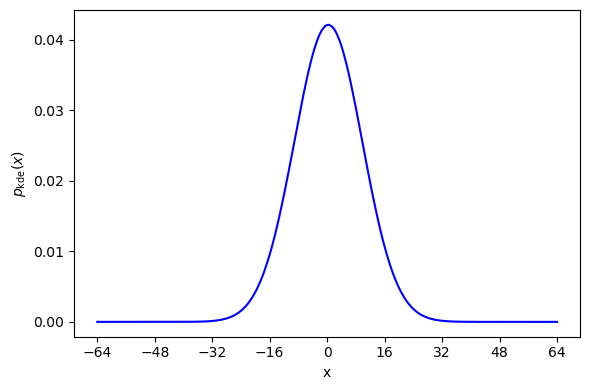

In [104]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))

ax.plot(xref, p0, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{\\rm kde}(x) \$")
ax.set_xticks(-64:16:64)
plt.tight_layout()
plt.show()

### Part 5: EM- Update $p_{\rm eq}$, Fix $D$ as water solvent environment 

Set number of iteration and output file name

In [15]:
D_init = 1000. # 500.
max_n_iteration = 30
f_out_pcontain = "/home/yizaochen/codes/julia/md_pisl/EM_data/peq_harmonic_well_0_first.jld"
f_out_d_record = "/home/yizaochen/codes/julia/md_pisl/EM_data/D_harmonic_well_0_first.jld"
f_out_l_record = "/home/yizaochen/codes/julia/md_pisl/EM_data/l_harmonic_well_0_first.jld";

In [16]:
p_container_0, D_records_0, log_likelihood_records_0 = complete_em_only_update_peq_given_p0(max_n_iteration, N, Nh, Np, xratio, xavg, Nv, tau, y_record, 
    save_freq, xref, e_norm, w0, f_out_pcontain, f_out_d_record, f_out_l_record, k_photon, p0, D_init);

Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Converged....EM Done.
Write p_container to /home/yizaochen/codes/julia/md_pisl/EM_data/peq_harmonic_well_0_first.jld
Write D_records to /home/yizaochen/codes/julia/md_pisl/EM_data/D_harmonic_well_0_first.jld
Write log_likelihood_records to /home/yizaochen/codes/julia/md_pisl/EM_data/l_harmonic_well_0_first.jld


### Part 6: Plots

#### Affine xref_ps to reduced-domain

In [17]:
xref_ps_affine = Affine.length_transform.(xref_ps);
p_eq_ps = rho_eq_ps .* rho_eq_ps
p_eq_ps = p_eq_ps / sum(w0 .* p_eq_ps);

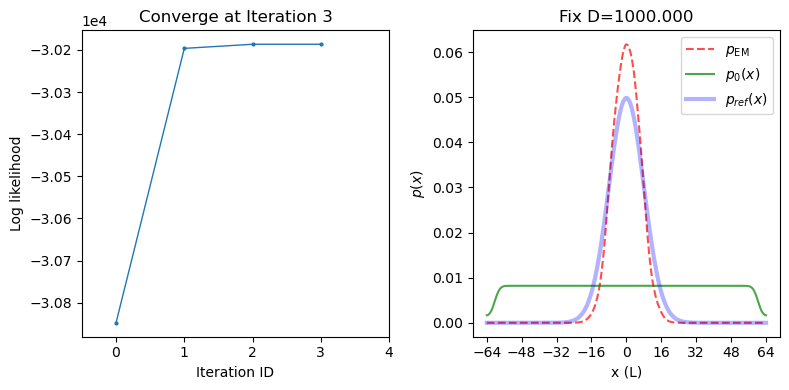

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

lastem_id = 3  

ax = axes[1]
xarray = 0:lastem_id
ax.plot(xarray, log_likelihood_records_0[1:lastem_id+1], "-o", linewidth=1, markersize=2)
ax.set_xlabel("Iteration ID")
ax.set_ylabel("Log likelihood")
ax.set_xlim(-0.5, lastem_id+1)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_title(@sprintf "Converge at Iteration %d" lastem_id)

ax = axes[2]
ax.plot(xref, p_container_0[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{\\rm EM}\$")
ax.plot(xref, p_container_0[1,:], label="\$ p_0(x) \$", alpha=0.7, color="green")
ax.plot(xref_ps_affine, p_eq_ps, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
ax.set_xlabel("x (L)")
ax.set_ylabel("\$ p(x) \$")
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "Fix D=%.3f" D_init)
ax.legend()

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/0/first_peq_em.svg")
plt.show()

### Part 7: Scan $l$ as change D and fix $p_{\rm eq}$

In [21]:
# Set D-array and peq
D_array = 100.:100.:1000.
l_array = zeros(length(D_array))
peq_scan_D = zeros(N, 1)
peq_scan_D[:, 1] = p_container_0[lastem_id+1, :];
# D_array = float(vcat(D_array_1, D_array_2, D_array_3))

In [22]:
d_idx = 1
for D_test in D_array
    l_array[d_idx] = get_loglikelihood(Nh, Np, xratio, xavg, peq_scan_D, D_test, Nv, tau, y_record, save_freq, k_photon_scan_D)
    d_idx += 1
end

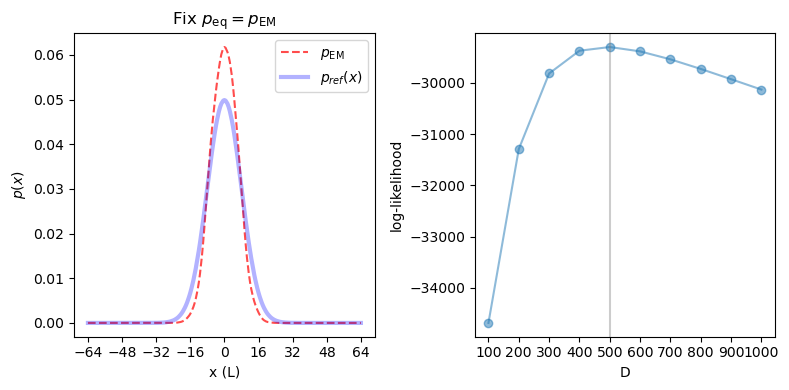

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax = axes[1]
ax.plot(xref, p_container_0[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{\\rm EM}\$")
ax.plot(xref_ps_affine, p_eq_ps, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
ax.set_xlabel("x (L)")
ax.set_ylabel("\$ p(x) \$")
ax.set_xticks(-64:16:64)
ax.set_title("Fix \$p_{\\rm eq} = p_{\\rm EM}\$")
ax.legend()

ax = axes[2]
ax.plot(D_array, l_array, "-o", alpha=0.5)
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D")
ax.axvline(D, color="grey", alpha=0.4)
#title = @sprintf "\$D=%.1f~~~\\Delta t=%.1e~~~T=%.1f~\$" D save_freq total_times
#ax.set_title(title)
ax.set_xticks(100:100:1000)

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/0/D_scan.svg")
plt.show()

### Part 8: EM2- Update $p_{\rm eq}$ fix $D=D_{\rm opt}$

In [26]:
D_init = 500. # 500
max_n_iteration = 30
f_out_pcontain = "/home/yizaochen/codes/julia/md_pisl/EM_data/peq_harmonic_well_0_second.jld"
f_out_d_record = "/home/yizaochen/codes/julia/md_pisl/EM_data/D_harmonic_well_0_second.jld"
f_out_l_record = "/home/yizaochen/codes/julia/md_pisl/EM_data/l_harmonic_well_0_second.jld";

In [28]:
p0 = zeros(N,1)
p0[:,1] = p_container_0[1, :];

In [29]:
p_container_1, D_records_1, log_likelihood_records_1 = complete_em_only_update_peq_given_p0(max_n_iteration, N, Nh, Np, xratio, xavg, Nv, tau, y_record, 
    save_freq, xref, e_norm, w0, f_out_pcontain, f_out_d_record, f_out_l_record, k_photon, p0, D_init);

Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Converged....EM Done.
Write p_container to /home/yizaochen/codes/julia/md_pisl/EM_data/peq_harmonic_well_0_second.jld
Write D_records to /home/yizaochen/codes/julia/md_pisl/EM_data/D_harmonic_well_0_second.jld
Write log_likelihood_records to /home/yizaochen/codes/julia/md_pisl/EM_data/l_harmonic_well_0_second.jld


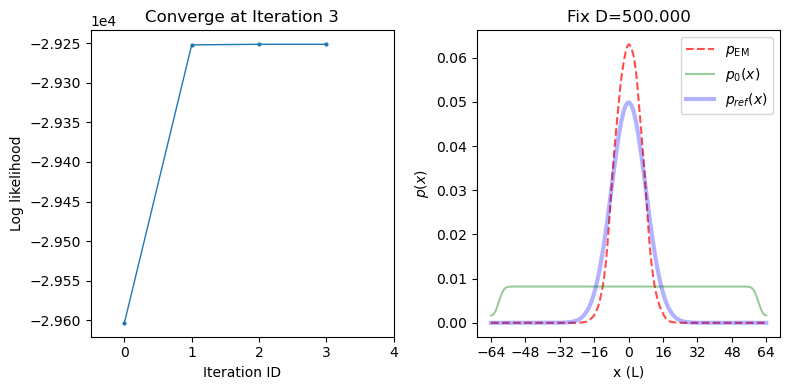

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

lastem_id = 3

ax = axes[1]
xarray = 0:lastem_id
ax.plot(xarray, log_likelihood_records_1[1:lastem_id+1], "-o", linewidth=1, markersize=2)
ax.set_xlabel("Iteration ID")
ax.set_ylabel("Log likelihood")
ax.set_xlim(-0.5, lastem_id+1)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_title(@sprintf "Converge at Iteration %d" lastem_id)

ax = axes[2]
ax.plot(xref, p_container_1[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{\\rm EM}\$")
ax.plot(xref, p_container_1[1,:], label="\$ p_0(x) \$", alpha=0.4, color="green")
ax.plot(xref_ps_affine, p_eq_ps, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
ax.set_xlabel("x (L)")
ax.set_ylabel("\$ p(x) \$")
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "Fix D=%.3f" D_init)
ax.legend()

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/0/second_peq_em.svg")
plt.show()

### Part 9: Convert $p_{\rm eq}$ and $D$ back to physical space

In [34]:
# Define Physical Domain
xratio_ps = 50. # unit: angstrom
xavg_ps = 50.   # unit: angstrom

N, xref_ps, w0_ps, Ldx_ps, w_ps = get_fem_xref_weights_basis(Nh, Np, xratio_ps, xavg_ps);

In [35]:
xref_affine_back = Affine.length_transform_inverse.(xref)
p_eq_affine_back = p_container_1[lastem_id+1, :]
p_eq_affine_back = p_eq_affine_back / sum(w0_ps .* p_eq_affine_back)
D_affine_back = Affine.D_transform_inverse(D_init);

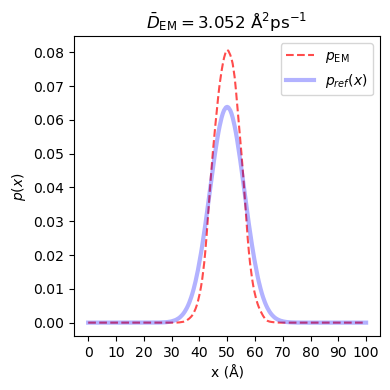

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

ax.plot(xref_ps, p_eq_affine_back, "--", color="red", alpha=0.7, label="\$p_{\\rm EM}\$")
ax.plot(xref_ps, rho_eq_ps .* rho_eq_ps, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
ax.set_xlabel("x (Å)")
ax.set_ylabel("\$ p(x) \$")
ax.set_xticks(0:10:100)
ax.set_title(@sprintf "\$\\bar{D}_{\\rm EM}=%.3f\$ Å\$^{2}\$ps\$^{-1}\$" D_affine_back)
ax.legend()

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/0/result_convert_back.svg")
plt.show()